In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
print("ready")

2023-02-15 12:34:59.431671: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-15 12:34:59.805906: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


ready


In [2]:
#model = keras.applications.xception.Xception(weights="imagenet")
#model = keras.models.load_model("p20_segmentation_model.keras")
model = keras.models.load_model("keras_p16_cnn_catdog_augemented_model.keras")
model.summary()

2023-02-15 12:35:11.594192: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-15 12:35:12.657972: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30967 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:88:00.0, compute capability: 7.0


Model: "my_augmented_catdog_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 90, 90, 3)]       0         
                                                                 
 sequential_8 (Sequential)   (None, 90, 90, 3)         0         
                                                                 
 my_scaling (Rescaling)      (None, 90, 90, 3)         0         
                                                                 
 my_conv2d_1 (Conv2D)        (None, 88, 88, 32)        896       
                                                                 
 my_pooling_1 (MaxPooling2D)  (None, 44, 44, 32)       0         
                                                                 
 my_conv2d_2 (Conv2D)        (None, 42, 42, 64)        18496     
                                                                 
 my_pooling_2 (MaxPooling2D)  (None, 21, 

In [3]:
#
# define image path and convert it to input array needed for the Xception model
#
#img_path = keras.utils.get_file(fname="cat.jpg",origin="https://en.wikipedia.org/wiki/File:June_odd-eyed-cat.jpg")
img_path = "/N/project/pfec_climo/ckieu/data/python/PetImages/Cat/18.jpg"

def get_img_array(img_path, target_size):
    img = keras.utils.load_img(img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array = keras.applications.xception.preprocess_input(array)
    return array

img_array = get_img_array(img_path, target_size=(90,90))
print(img_array.shape)
preds = model.predict(img_array)
print(preds[0])
np.argmax(preds)

(1, 90, 90, 3)


2023-02-15 12:35:24.052708: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401


1/1 [==============================] - 8s 8s/step
[0.0035511]


0

In [5]:
#
# set up a model that returns the last conv layer
#
last_conv_layer_name = "my_conv2d_5"
classifier_layer_names = ["my_dense"]
last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

In [6]:
#
# Apply the classifier on top of the last convolutional output
#
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input,x)

In [7]:
#
# retrieving gradient of the top predicted class
#
with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(img_array)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    #top_pred_index = tf.argmax(preds[0])
    top_pred_index = 0
    top_class_channel = preds[:,top_pred_index]

grads = tape.gradient(top_class_channel, last_conv_layer_output)
last_conv_layer_output.shape

TensorShape([1, 1, 1, 256])

In [8]:
#
# gradient pooling and channel-importance weighting
#
pooled_grads = tf.reduce_mean(grads, axis=(0,1,2)).numpy()
print(pooled_grads.shape[-1])
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:,:,i] *= pooled_grads[i]

heatmap = np.mean(last_conv_layer_output, axis=-1)
#heatmap = last_conv_layer_output
heatmap.shape

256


(1, 1)

/tmp/ipykernel_31317/2361906273.py:5: RuntimeWarning: invalid value encountered in divide
  heatmap /= np.max(heatmap)


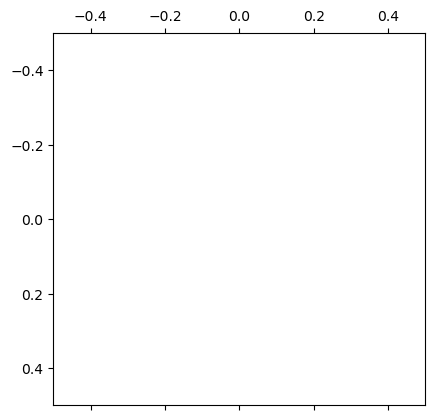

In [9]:
#
# plotting
#
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
#print(heatmap[0])
plt.matshow(heatmap)

/tmp/ipykernel_31317/2849418809.py:8: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255*heatmap)
/tmp/ipykernel_31317/2849418809.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


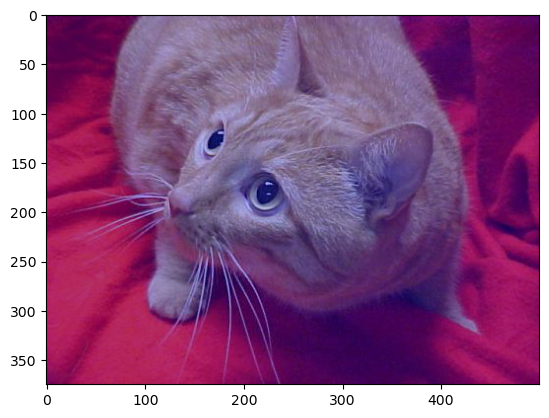

In [10]:
#
# superimposed heatmap on an image
#
import matplotlib.cm as cm
img = keras.utils.load_img(img_path)
img = keras.utils.img_to_array(img)

heatmap = np.uint8(255*heatmap)

jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:,:3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1],img.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap*0.4 + img
superimposed_img = keras.utils.array_to_img(superimposed_img)
plt.imshow(superimposed_img)
plt.show()
